### Part b

In [1]:
import pickle
import torch
import torchvision
import heapq 
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import itertools
from torchvision import transforms
from PIL import Image

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def get_train_data():
    for n in range(1,6):
        train_batch_dict = unpickle('data_batch_' + str(n))
        if n == 1:
            x_train_set = np.array(train_batch_dict[b'data'])
            y_train_set = np.array(train_batch_dict[b'labels'])
        else:
            x_train_set = np.concatenate([x_train_set, train_batch_dict[b'data']], axis=0)
            y_train_set = np.concatenate([y_train_set, train_batch_dict[b'labels']], axis=0)
    return x_train_set, y_train_set

In [4]:
def get_test_data():
    test_batch_dict = unpickle('test_batch')
    x_test_set = np.array(test_batch_dict[b'data'])
    y_test_set = np.array(test_batch_dict[b'labels'])
    return x_test_set, y_test_set

In [5]:
def get_cifar10_classes():
    class_names_dict = unpickle('batches.meta')
    class_names_list = []
    for name in class_names_dict[b'label_names']:
        class_names_list.append(str(name)[2:-1])

    return class_names_list

In [6]:
def get_imagenet_classes():
    # read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    return categories

In [7]:
def get_alexnet_pretrained_model():
    # load pre-trained AlexNet model
    model = torch.hub.load('pytorch/vision:v0.8.0', 'alexnet', pretrained=True)
    model.eval()
    return model

In [8]:
def get_preprocess():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess

In [9]:
# predicts the values for each image and also finds top n predicted classes
def predict(model, data, n):
    imagenet_classes = get_imagenet_classes()
    counts = {}.fromkeys(imagenet_classes, 0)
    y_predict = []
    for index in range(0, len(data)):

        current_image = data[index].reshape(3, 32, 32).transpose(1, 2, 0)
        input_image = Image.fromarray(current_image, mode='RGB')

        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

        output = model(input_batch)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        top_prob, top_catid = torch.topk(probabilities, 1)
        counts[imagenet_classes[top_catid[0]]] += 1

        y_predict.append(imagenet_classes[top_catid[0]])
    
    top_predicted = heapq.nlargest(n, counts, key=counts.get)
    return top_predicted, y_predict

In [10]:
def create_confusion_matrix(n, top_predicted_classes, predicted_classes, true_indexes):
    
    confusion_matrix = [ [ 0 for i in range(n) ] for j in range(n) ]

    # maps every top predicted class to an index in 0, n range
    top_predicted_dict = {}
    for index in range(n):
        top_predicted_dict[top_predicted_classes[index]] = index
    
    for index in range (0, len(predicted_classes)): 
        curr_predicted_class = predicted_classes[index]
        
        if curr_predicted_class in top_predicted_classes:
            true_index = true_indexes[index]
            predicted_index = top_predicted_dict[curr_predicted_class]
            confusion_matrix[true_index][predicted_index] += 1
            
    return confusion_matrix

In [11]:
def plot_confusion_matrix(cm,
                          x_classes,
                          y_classes,
                          title='Confusion matrix'):

    cmap = plt.get_cmap('RdPu')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    x_tick_marks = np.arange(len(x_classes))
    plt.xticks(x_tick_marks, x_classes, rotation=75)
    
    y_tick_marks = np.arange(len(y_classes))
    plt.yticks(y_tick_marks, y_classes)

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 "{:,}".format(cm[i, j]),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [12]:
n = 10
cifar10_classes = get_cifar10_classes()

x_train, y_train = get_train_data()
x_test, y_test = get_test_data()

alexnet = get_alexnet_pretrained_model()
preprocess = get_preprocess()

Using cache found in /Users/maryamkarimi/.cache/torch/hub/pytorch_vision_v0.8.0


In [13]:
top_predicted_classes, y_predict = predict(model = alexnet,
                                           data = x_test,
                                           n = n)

In [14]:
confusion_matrix = create_confusion_matrix(n = n,
                                           top_predicted_classes = top_predicted_classes,
                                           predicted_classes = y_predict,
                                           true_indexes = y_test)

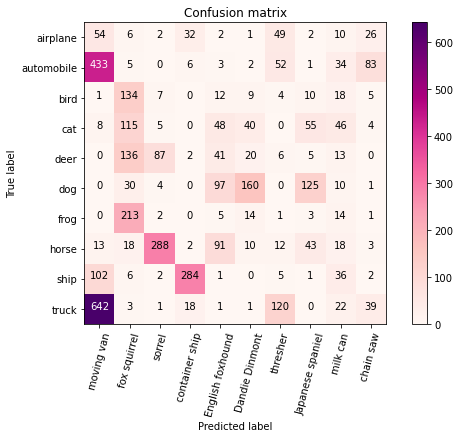

In [15]:
plot_confusion_matrix(cm = np.array(confusion_matrix),
                      x_classes = top_predicted_classes,
                      y_classes = cifar10_classes)

#### Part c and d

In [16]:
def extract_features(model, data):
    result = []
    
    for i in range(len(data)):
        current_image = data[i].reshape(3, 32, 32).transpose(1, 2, 0)
        input_image = Image.fromarray(current_image, mode='RGB')
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)
        result.append(model(input_batch).detach().numpy()[0])
    
    return result

In [17]:
def find_best_classifier(x_validation, y_validation, alexnet):
    
    clf = SGDClassifier(shuffle=True, loss='log')
    
    params = {'alpha': 10.0**-np.arange(1,7)}
    gs = GridSearchCV(clf, params, scoring='accuracy')
    
    x_validation_features = extract_features(model = alexnet,
                                             data = x_validation)
    gs.fit(x_validation_features, y_validation)
    
    return gs.best_estimator_

In [18]:
def train_and_predict(clf, model, x_train_portion, x_test, y_train_portion, y_test):

    # train one batch of the data at a time
    for i in range(40):
        x_train_portion_features = extract_features(model = alexnet,
                                                    data = x_train_portion[1000 * i :
                                                                           1000 * (i + 1)])
        clf.partial_fit(x_train_portion_features,
                        y_train_portion[1000 * i : 1000 * (i + 1)],
                        np.arange(10))
        
        if ((1000 * (i + 1)) % 10000 == 0):
            print(str(1000 * (i + 1) / 400) + '% completed')

    print('starting prediction...')
    x_test_features = extract_features(model = alexnet,
                                       data = x_test)

    # predict on unseen data
    y_pred = clf.predict(x_test_features)
    
    return y_pred

In [19]:
x_train_portion, x_validation, y_train_portion, y_validation = train_test_split(x_train,
                                                                                y_train,
                                                                                test_size=0.2,
                                                                                random_state=0)

In [20]:
alexnet = get_alexnet_pretrained_model()

# remove the last 2 fully-connected layers
fc6 = torch.nn.Sequential(*list(alexnet.classifier.children())[:-2])
alexnet.classifier = fc6

# tune the parameters and find the best classifier
clf = find_best_classifier(x_validation, y_validation, alexnet)

y_pred = train_and_predict(clf,
                           alexnet,
                           x_train_portion,
                           x_test,
                           y_train_portion,
                           y_test)

Using cache found in /Users/maryamkarimi/.cache/torch/hub/pytorch_vision_v0.8.0


25.0% completed
50.0% completed
75.0% completed
100.0% completed
starting prediction...


Accuracy w/ fc6:  0.7776


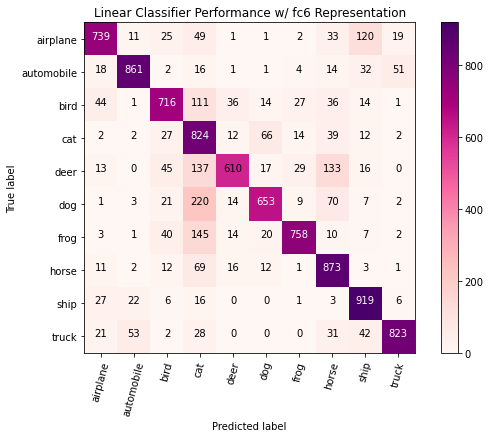

In [21]:
print('Accuracy w/ fc6: ', metrics.accuracy_score(y_test, y_pred))
plot_confusion_matrix(cm = metrics.confusion_matrix(y_test, y_pred),
                      x_classes = cifar10_classes,
                      y_classes = cifar10_classes,
                      title = 'Linear Classifier Performance w/ fc6 Representation')

In [22]:
alexnet = get_alexnet_pretrained_model()

# remove the last fully-connected layer
fc7 = torch.nn.Sequential(*list(alexnet.classifier.children())[:-1])
alexnet.classifier = fc7

# tune the parameters and find the best classifier
clf = find_best_classifier(x_validation, y_validation, alexnet)

y_pred = train_and_predict(clf,
                           alexnet,
                           x_train_portion,
                           x_test,
                           y_train_portion,
                           y_test)

Using cache found in /Users/maryamkarimi/.cache/torch/hub/pytorch_vision_v0.8.0


25.0% completed
50.0% completed
75.0% completed
100.0% completed
starting prediction...


Accuracy w/ fc7:  0.8198


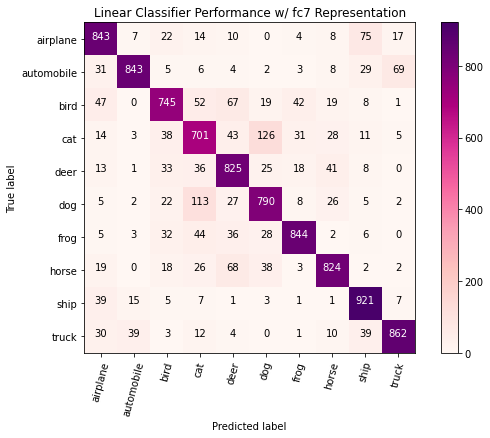

In [23]:
print('Accuracy w/ fc7: ', metrics.accuracy_score(y_test, y_pred))
plot_confusion_matrix(cm = metrics.confusion_matrix(y_test, y_pred),
                      x_classes = cifar10_classes,
                      y_classes = cifar10_classes,
                      title = 'Linear Classifier Performance w/ fc7 Representation')